In [2]:
import os
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
sns.set()

In [3]:
datadir = "data/tidy_data"
data = os.path.join(datadir, "new_jump_data.csv")
df_jump = pd.read_csv(data)

# Importing the dataset
datadir = "data/tidy_data"
data = os.path.join(datadir, "coded_injuries.csv")
df_injuries = pd.read_csv(data)

# Function for converting date format from American to ISO formatting
def date_coversion(date):
    date_object = datetime.strptime(date, '%m-%d-%Y')
    iso_format_date = date_object.strftime('%Y-%m-%d')
    return iso_format_date

# Changing date formatting
df_injuries.drop(columns = ["DateOfReturn", "ReportedDate"], inplace = True)
df_injuries["ProblemDate"] = df_injuries["ProblemDate"].str.replace("/", "-").apply(date_coversion)
df_injuries["ProblemDate"] = pd.to_datetime(df_injuries["ProblemDate"])

# Filling NA's
df_injuries["Side"] = df_injuries["Side"].fillna("Does Not Apply")

In [4]:
numeric_columns = df_jump.select_dtypes(include=['number']).columns
correlation_matrix = df_jump[numeric_columns].corr()

correlation_matrix_abs = correlation_matrix.abs().unstack().sort_values(ascending=False)
top_correlations = correlation_matrix_abs[correlation_matrix_abs < 1.0].drop_duplicates().head(30)

top_correlations

Propulsive Net Impulse                Jump Momentum                         0.999967
Relative Propulsive Net Impulse       Takeoff Velocity                      0.999908
Peak Braking Velocity                 Relative Braking Net Impulse          0.999835
Takeoff Velocity                      Peak Velocity                         0.997807
Peak Velocity                         Relative Propulsive Net Impulse       0.997660
L|R Avg. Braking Force                L|R Braking Impulse Index             0.997610
Takeoff Velocity                      Jump Height                           0.997022
Relative Propulsive Net Impulse       Jump Height                           0.996937
L|R Avg. Landing Force                L|R Landing Impulse Index             0.996110
Peak Braking Force                    Force at Min Displacement             0.996072
L|R Propulsive Impulse Index          L|R Avg. Propulsive Force             0.995557
Peak Velocity                         Jump Height                

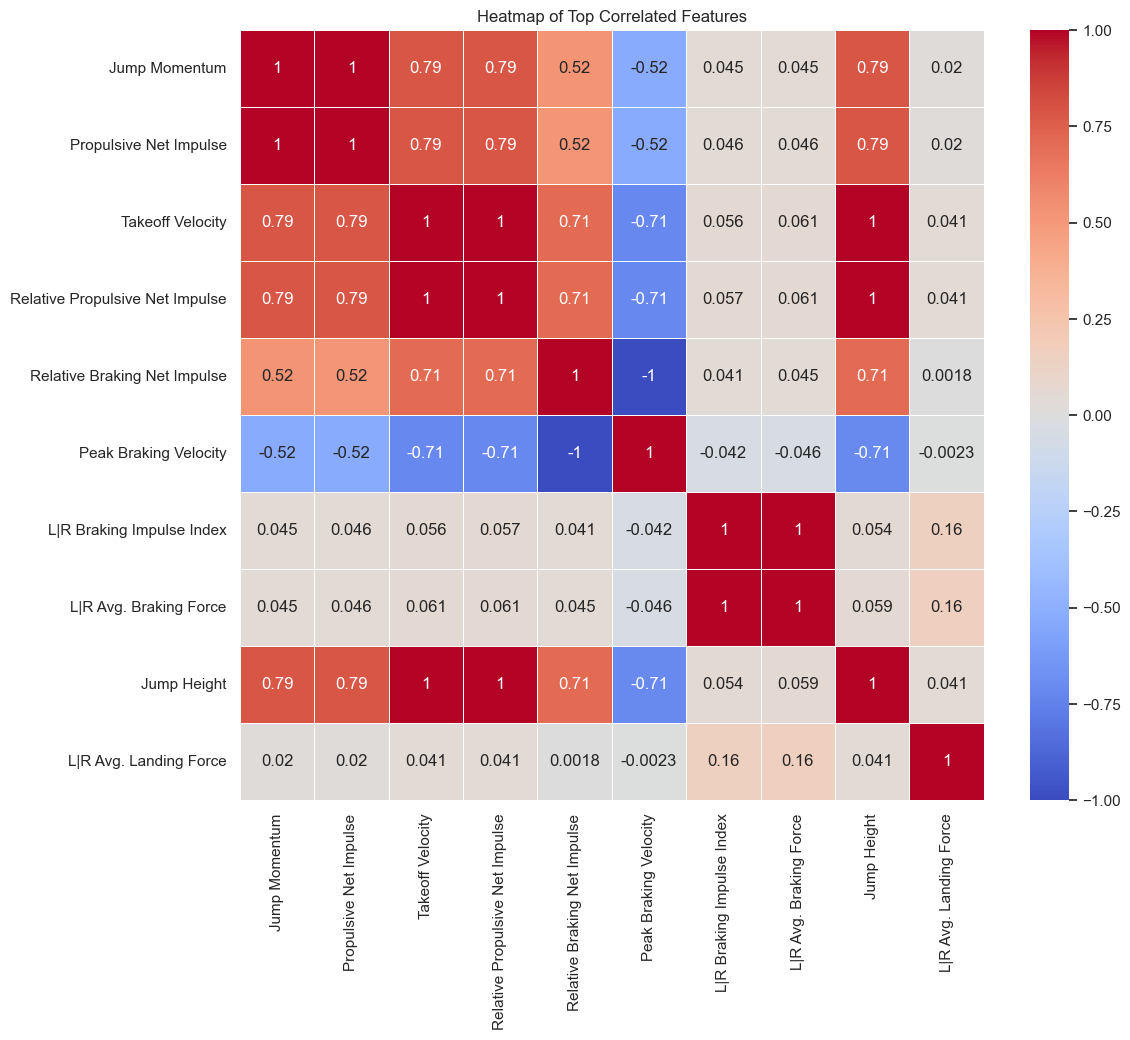

In [5]:
top_features = ['Jump Momentum', 'Propulsive Net Impulse', 'Takeoff Velocity', 
                'Relative Propulsive Net Impulse', 'Relative Braking Net Impulse', 
                'Peak Braking Velocity', 'L|R Braking Impulse Index', 
                'L|R Avg. Braking Force', 'Jump Height', 'L|R Avg. Landing Force']

plt.figure(figsize=(12, 10))
sns.heatmap(df_jump[top_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Heatmap of Top Correlated Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

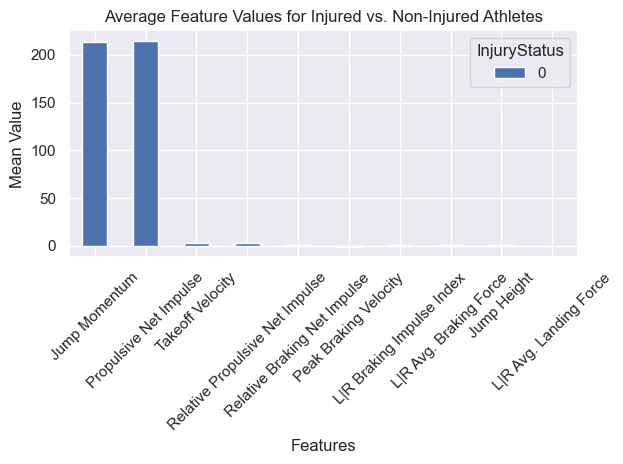

In [5]:
# Assume `injury_status` column exists (create it if needed)
df_jump['InjuryStatus'] = df_jump['TestId'].apply(lambda x: 1 if x in df_injuries['Code'].values else 0)

# Plot mean comparison
plt.figure(figsize=(12, 6))
df_jump.groupby('InjuryStatus')[top_features].mean().transpose().plot(kind='bar')
plt.title("Average Feature Values for Injured vs. Non-Injured Athletes")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean Squared Error: 0.0024268866042016462
R-squared: 0.8935906657453474


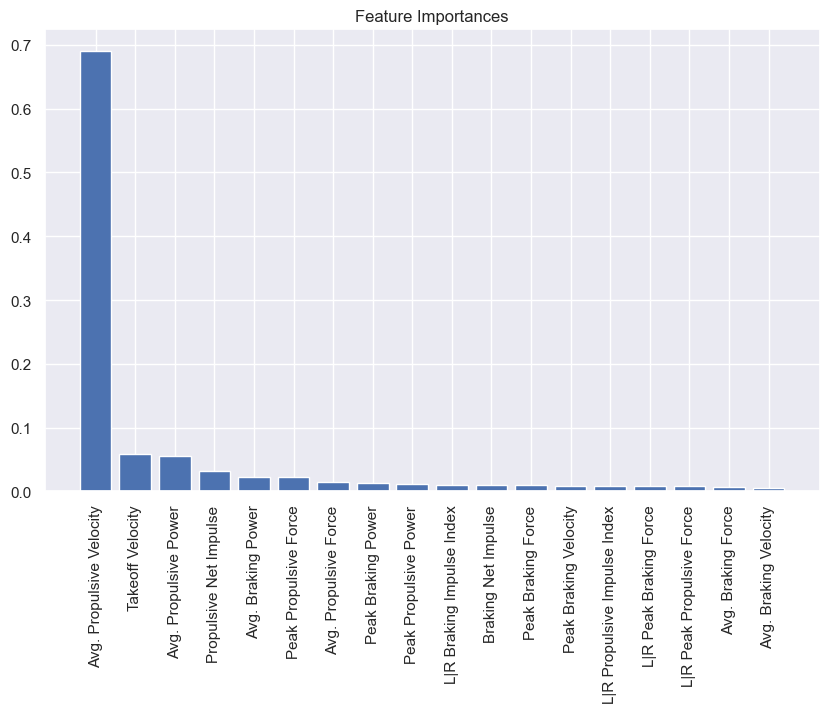

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select relevant columns
jump_data = df_jump[[
    'TestId', 'Peak Braking Force', 'Avg. Braking Force', 'Braking Net Impulse',
    'Peak Propulsive Force', 'Avg. Propulsive Force', 'Propulsive Net Impulse',
    'Avg. Braking Velocity', 'Peak Braking Velocity', 'Avg. Propulsive Velocity',
    'Takeoff Velocity', 'Avg. Braking Power', 'Peak Braking Power', 'Avg. Propulsive Power',
    'Peak Propulsive Power', 'L|R Peak Braking Force', 'L|R Peak Propulsive Force',
    'L|R Braking Impulse Index', 'L|R Propulsive Impulse Index', 'mRSI'
]]

jump_data.set_index("TestId", inplace= True)
# Handle missing values by dropping rows with NaNs
jump_data = jump_data.dropna()

# Split data into training and testing sets
X = jump_data.drop(columns=['mRSI'])
y = jump_data['mRSI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Train Random Forest model with cross-validation
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rf_model.fit(X_train, y_train)

# Predict on the test set
predictions = rf_model.predict(X_test)

# Model performance evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Variable Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.show()

In [7]:
# Assuming jump_data is already loaded
jump_data['mRSI_Category'] = pd.cut(
    jump_data['mRSI'],
    bins=[-float('inf'), 0.3, 0.6, 0.8, 1.05],
    labels=["Low", "Moderate", "Well Established", "High Level"]
)

# Drop the original mRSI column if only using mRSI_Category
jump_data = jump_data.drop(columns=['mRSI'])

# Display the updated DataFrame
print(jump_data.head())

                      Peak Braking Force  Avg. Braking Force  \
TestId                                                         
Fi8mQYEOLfWgIOOnFAHq              2544.0           1652.2734   
u4Gflwwp9Yq6WDEGzaPP              2337.0           1765.1327   
qUm2TLbIVDS7WfJY4KNo              2478.0           1870.3592   
PGeIe7m2OEv45zjiGqw6              2055.0           1249.1034   
9qk6Kl0wcEf5HTP9Kw5e              2871.0           2197.3419   

                      Braking Net Impulse  Peak Propulsive Force  \
TestId                                                             
Fi8mQYEOLfWgIOOnFAHq              99.0612                 2739.0   
u4Gflwwp9Yq6WDEGzaPP             114.2178                 2352.0   
qUm2TLbIVDS7WfJY4KNo             114.6998                 2496.0   
PGeIe7m2OEv45zjiGqw6              84.3201                 2317.0   
9qk6Kl0wcEf5HTP9Kw5e             149.7068                 2872.0   

                      Avg. Propulsive Force  Propulsive Net Impulse  \
Tes

Accuracy: 80.35%


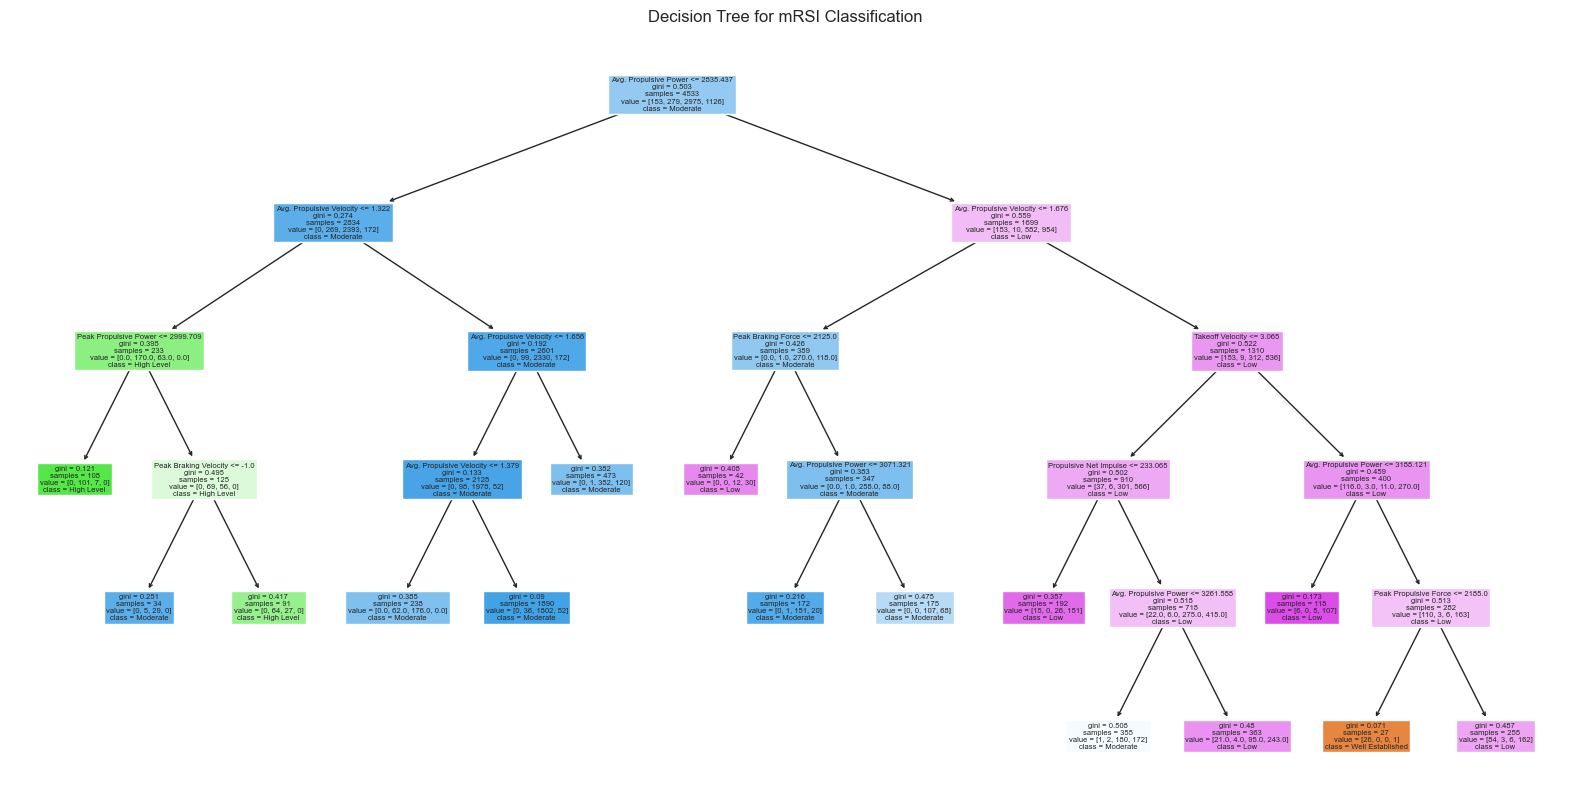

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming 'jump_data' is already loaded and preprocessed
# Splitting data into features and labels
X = jump_data.drop(columns=['mRSI_Category'])  # Features
y = jump_data['mRSI_Category']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fit a decision tree model
tree_model = DecisionTreeClassifier(
    random_state=123,
    max_depth=5,  # Limit the depth of the tree
    min_samples_split=10,  # Minimum samples required to split a node
    min_samples_leaf=5,  # Minimum samples required at a leaf node
    max_leaf_nodes=15  # Limit the number of leaf nodes
)
tree_model.fit(X_train, y_train)

# Predict on the test set
predictions = tree_model.predict(X_test)

# Evaluate the model performance
conf_matrix = confusion_matrix(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=y.unique(), filled=True)
plt.title("Decision Tree for mRSI Classification")
plt.show()

In [9]:
# Importing the dataset
datadir = "data/tidy_data"
data = os.path.join(datadir, "new_jump_data.csv")
df_jump_new = pd.read_csv(data)

df_jump_new["injury_log"] = df_jump_new["injury_type"]
df_jump_new["injury_log"] = df_jump_new["injury_log"].mask(df_jump_new["injury_type"].notna(), 1).fillna(0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_67668\4262125786.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_jump_new["injury_log"] = df_jump_new["injury_log"].mask(df_jump_new["injury_type"].notna(), 1).fillna(0)


In [10]:
df_jump_new.head(10)

,athlete_code,TestId,Date,Time,Gender,Position,Type,Excluded,Tags,System Weight,...,problem_date,return_date,reported_date,body_part,affected_area,side_of_body,injury_type,specific_part,current_status,injury_log
0,BASEB1,LBrzNxXMkCckqH6I37FC,04-16-2024,15:20:26,Men,NaN,Countermovement Jump,NaN,NaN,730.371,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
1,BASEB1,obdaLJJpA0veWNEbkgXZ,04-19-2024,14:54:35,Men,NaN,Countermovement Jump,NaN,NaN,738.274,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
2,BASEB1,xs4JaGoWbT6u3GfMrbMn,04-04-2024,15:21:41,Men,NaN,Countermovement Jump,NaN,NaN,759.976,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
3,BASEB1,2NXcR02pojld48VtJVsv,03-28-2024,15:20:09,Men,NaN,Countermovement Jump,NaN,NaN,743.065,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
4,BASEB1,idgUsdGMwwCRgpF1UlEC,04-19-2024,14:53:51,Men,NaN,Countermovement Jump,NaN,NaN,738.847,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
5,BASEB1,ViVjEy36g6Vg9rG7wt5c,03-19-2024,15:21:54,Men,NaN,Countermovement Jump,NaN,NaN,747.203,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
6,BASEB1,C9N3YAnAgTDSJFtWxe2S,02-08-2024,15:20:36,Men,NaN,Countermovement Jump,NaN,NaN,766.677,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
7,BASEB1,50GBjt8YXlttEQ9mYY3b,04-11-2024,15:20:53,Men,NaN,Countermovement Jump,NaN,NaN,747.418,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
8,BASEB1,UaW6m8vGWoQxzIWVyYqz,02-13-2024,15:24:09,Men,NaN,Countermovement Jump,NaN,NaN,776.647,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1
9,BASEB1,MDfXklrgGsMM1VHkZA4Z,01-23-2024,15:22:09,Men,NaN,Countermovement Jump,NaN,NaN,785.861,...,03-09-2024,03-09-2024,03-13-2024,Knee,Lower Extremity,Left,Fat Pad Syndrome,NaN,Returned To Play As Tolerated,1


In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

# Select relevant columns
jump_data = df_jump_new[[
    'TestId', 'Peak Braking Force', 'Avg. Braking Force', 'Braking Net Impulse',
    'Peak Propulsive Force', 'Avg. Propulsive Force', 'Propulsive Net Impulse',
    'Avg. Braking Velocity', 'Peak Braking Velocity', 'Avg. Propulsive Velocity',
    'Takeoff Velocity', 'Avg. Braking Power', 'Peak Braking Power', 'Avg. Propulsive Power',
    'Peak Propulsive Power', 'L|R Peak Braking Force', 'L|R Peak Propulsive Force',
    'L|R Braking Impulse Index', 'L|R Propulsive Impulse Index', 'mRSI'
]]

jump_data.set_index("TestId", inplace= True)
# Handle missing values by dropping rows with NaNs
jump_data = jump_data.dropna()

min_max_scaler = preprocessing.MinMaxScaler()

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

# Select relevant columns
jump_data = df_jump_new[[
    'TestId', 'Peak Braking Force', 'Avg. Braking Force', 'Braking Net Impulse',
    'Peak Propulsive Force', 'Avg. Propulsive Force', 'Propulsive Net Impulse',
    'Avg. Braking Velocity', 'Peak Braking Velocity', 'Avg. Propulsive Velocity',
    'Takeoff Velocity', 'Avg. Braking Power', 'Peak Braking Power', 'Avg. Propulsive Power',
    'Peak Propulsive Power', 'L|R Peak Braking Force', 'L|R Peak Propulsive Force',
    'L|R Braking Impulse Index', 'L|R Propulsive Impulse Index', 'mRSI'
]]

jump_data.set_index("TestId", inplace= True)
# Handle missing values by dropping rows with NaNs
jump_data = jump_data.dropna()

# Split data into training and testing sets
X = jump_data.drop(columns=['mRSI'])
y = jump_data[['mRSI']]

x_minmax = min_max_scaler.fit_transform(X)

In [19]:

y_minmax = min_max_scaler.fit_transform(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x_minmax, y_minmax, test_size=0.3, random_state=123)

# Train Random Forest model with cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rf_model.fit(X_train, y_train)

# Predict on the test set
predictions = rf_model.predict(X_test)

# Model performance evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Variable Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.show()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConvers

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 421, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 831, in _validate_y_class_weight
    check_classification_targets(y)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py", line 221, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [22]:
jump_logistic = df_jump_new[[
    'TestId', 'Peak Braking Force', 'Avg. Braking Force', 'Braking Net Impulse',
    'Peak Propulsive Force', 'Avg. Propulsive Force', 'Propulsive Net Impulse',
    'Avg. Braking Velocity', 'Peak Braking Velocity', 'Avg. Propulsive Velocity',
    'Takeoff Velocity', 'Avg. Braking Power', 'Peak Braking Power', 'Avg. Propulsive Power',
    'Peak Propulsive Power', 'L|R Peak Braking Force', 'L|R Peak Propulsive Force',
    'L|R Braking Impulse Index', 'L|R Propulsive Impulse Index', 'mRSI', 'injury_log'
]]

jump_logistic.set_index("TestId", inplace= True)
# Handle missing values by dropping rows with NaNs
jump_logistic = jump_logistic.dropna()


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients for the predictors:
[[-0.93602017  0.31728102  0.18399703 -0.20425136 -0.03059892 -0.67944234
  -0.74028137  1.51799569  0.16908342 -0.4350009  -1.06683805 -0.08003768
  -0.69669661  1.437489    0.21772828  0.21589468 -0.44522351 -0.22799291
   0.24660596]]


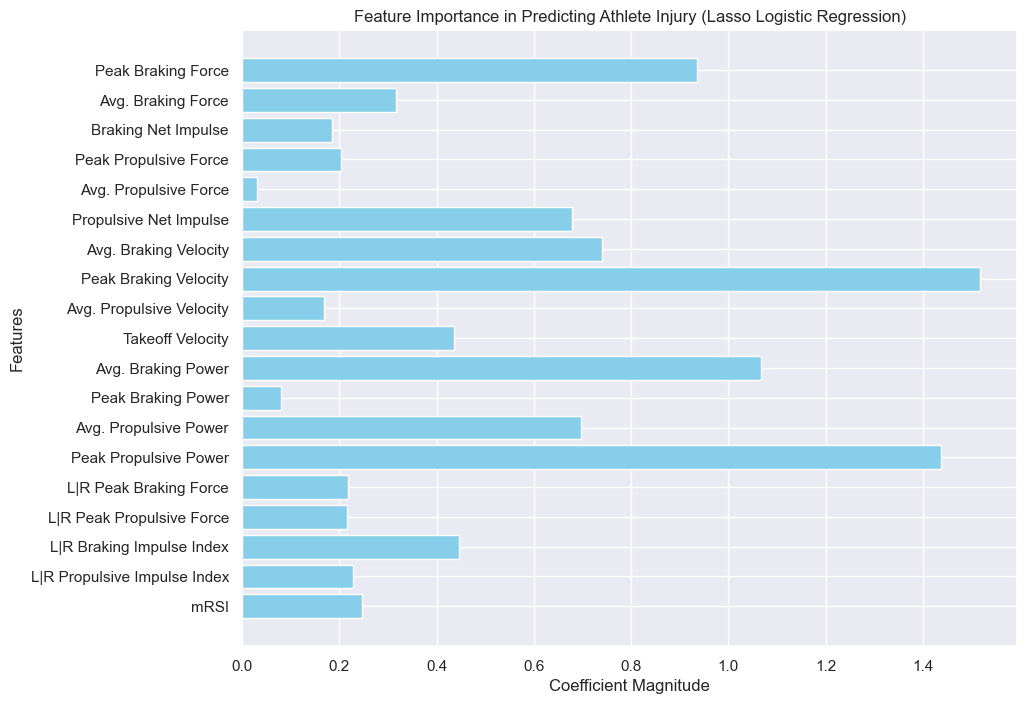

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = jump_logistic.drop(columns=['injury_log'])
y = jump_logistic[['injury_log']]


imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Set random seed for reproducibility
np.random.seed(123)

# Standardize the features (important for Lasso)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize and fit the Lasso (Logistic Regression with L1 penalty)
lasso_model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
lasso_model.fit(X, y)

# Get the coefficients to interpret which predictors are most significant
coef = lasso_model.coef_

# Print the coefficients
print("Coefficients for the predictors:")
print(coef)

# Get the feature names (since X was transformed, we use jump_logistic columns)
feature_names = jump_logistic.drop(columns=['injury_log']).columns

# Get absolute values of coefficients to show magnitude in bar plot
coefficients = np.abs(lasso_model.coef_[0])

# Create a bar plot of the coefficients
plt.figure(figsize=(10, 8))
plt.barh(feature_names, coefficients, color="skyblue")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Athlete Injury (Lasso Logistic Regression)")
plt.gca().invert_yaxis()  # Optional: inverts y-axis for easier readability
plt.show()